In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv(DATA_PATH)

if "default_flag_v3" not in df.columns:
    df["default_flag_v3"] = np.where(
        (df["return_rate"] >= 0.40) |
        ((df["return_rate"] >= 0.20) & (df["total_profit"] < 0) & (df["avg_discount"] >= 0.30)),
        1, 0
    )


TARGET = "default_flag_v3"

# Leakage-safe features (same as modeling)
leakage_features = ["return_rate", "avg_discount", "total_profit"]

features = [
    c for c in df.columns
    if c != TARGET
    and pd.api.types.is_numeric_dtype(df[c])
    and c not in leakage_features
]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[TARGET],
    test_size=0.20,
    random_state=42,
    stratify=df[TARGET]
)


In [6]:
def calculate_psi(expected, actual, bins=10):
    """
    expected: baseline array (e.g., training)
    actual: monitoring array (e.g., new data)
    """
    expected = pd.Series(expected)
    actual = pd.Series(actual)

    # Define bins using expected distribution
    quantiles = np.linspace(0, 1, bins + 1)
    breakpoints = expected.quantile(quantiles).values
    breakpoints[0] = -np.inf
    breakpoints[-1] = np.inf

    expected_bins = pd.cut(expected, breakpoints, duplicates='drop')
    actual_bins = pd.cut(actual, breakpoints, duplicates='drop')

    expected_dist = expected_bins.value_counts(normalize=True).sort_index()
    actual_dist = actual_bins.value_counts(normalize=True).sort_index()

    psi = np.sum(
        (expected_dist - actual_dist) *
        np.log((expected_dist + 1e-8) / (actual_dist + 1e-8))
    )

    return psi

In [7]:
psi_results = []

for f in features:
    psi_value = calculate_psi(
        X_train[f],
        X_test[f],
        bins=10
    )
    psi_results.append({
        "feature": f,
        "psi": psi_value
    })

psi_df = pd.DataFrame(psi_results).sort_values("psi", ascending=False)
psi_df


,feature,psi
2,avg_shipping_delay,0.003180
1,total_sales,0.002989
3,customer_tenure_days,0.002445
4,orders_per_year,0.001731
0,total_orders,0.001043
5,default_flag,0.000297


In [8]:
def psi_flag(psi):
    if psi < 0.10:
        return "Stable"
    elif psi < 0.25:
        return "Monitor"
    else:
        return "Drift"

psi_df["status"] = psi_df["psi"].apply(psi_flag)
psi_df


,feature,psi,status
2,avg_shipping_delay,0.003180,Stable
1,total_sales,0.002989,Stable
3,customer_tenure_days,0.002445,Stable
4,orders_per_year,0.001731,Stable
0,total_orders,0.001043,Stable
5,default_flag,0.000297,Stable


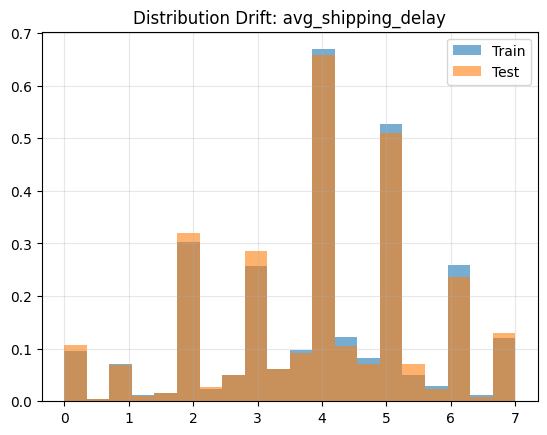

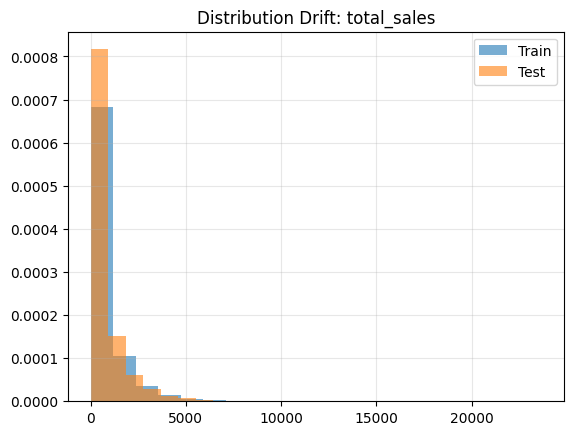

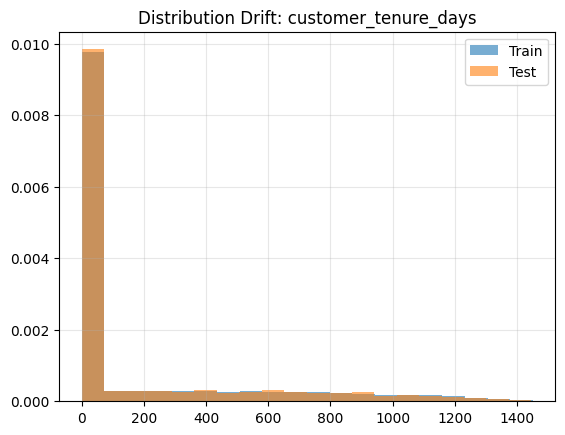

In [9]:
top_drift_features = psi_df.head(3)["feature"].tolist()

for f in top_drift_features:
    plt.figure()
    plt.hist(X_train[f], bins=20, alpha=0.6, density=True, label="Train")
    plt.hist(X_test[f], bins=20, alpha=0.6, density=True, label="Test")
    plt.title(f"Distribution Drift: {f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [10]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    random_state=42
)

xgb_model.fit(X_train, y_train)

pd_train = xgb_model.predict_proba(X_train)[:, 1]
pd_test  = xgb_model.predict_proba(X_test)[:, 1]


In [11]:
score_psi = calculate_psi(pd_train, pd_test, bins=10)
score_psi


np.float64(0.004312112107539524)

In [12]:
if "customer_tenure_days" in df.columns:
    df_monitor = df.copy()
    df_monitor["pd"] = xgb_model.predict_proba(df[features])[:, 1]

    df_monitor["tenure_bin"] = pd.qcut(
        df_monitor["customer_tenure_days"],
        5,
        duplicates="drop"
    )

    psi_by_segment = []

    for seg, sub in df_monitor.groupby("tenure_bin"):
        psi_val = calculate_psi(pd_train, sub["pd"], bins=10)
        psi_by_segment.append({
            "segment": str(seg),
            "psi": psi_val
        })

    pd.DataFrame(psi_by_segment)


/tmp/ipython-input-2476511630.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, sub in df_monitor.groupby("tenure_bin"):
